# MergeSpectroPhotoFactory

- creation date : July 4th 2019
- author Sylvie Dagoret

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec

import numpy as np
import os
from scipy.interpolate import interp1d

from astropy.time import Time


In [40]:
#old = np.load
#np.load = lambda *a,**k: old(*a,**k,allow_pickle=True)

In [41]:
from astropy.table import Table,QTable

In [42]:
plt.rcParams["axes.labelsize"]="large"
plt.rcParams["axes.linewidth"]=2.0
plt.rcParams["xtick.major.size"]=8
plt.rcParams["ytick.major.size"]=8
plt.rcParams["ytick.minor.size"]=5
plt.rcParams["xtick.labelsize"]="large"
plt.rcParams["ytick.labelsize"]="large"

plt.rcParams["figure.figsize"]=(10,10)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titleweight'] = 'bold'
#plt.rcParams['axes.facecolor'] = 'blue'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['lines.markeredgewidth'] = 0.3 # the line width around the marker symbol
plt.rcParams['lines.markersize'] = 5  # markersize, in points
plt.rcParams['grid.alpha'] = 0.75 # transparency, between 0.0 and 1.0
plt.rcParams['grid.linestyle'] = '-' # simple line
plt.rcParams['grid.linewidth'] = 0.4 # in points
plt.rcParams['font.size'] = 13

In [43]:
import os
from os import listdir
from os.path import isfile, join
import re
import sys

if not 'workbookDir' in globals():
    workbookDir = os.getcwd()
print('workbookDir: ' + workbookDir)

spectractordir=workbookDir+"/../../Spectractor"
print('spectractordir: ' + spectractordir)
toolsdir=workbookDir+"/../common_tools"
print("toolsdir:",toolsdir)


sys.path.append(workbookDir)
sys.path.append(spectractordir)
sys.path.append(os.path.dirname(workbookDir))
sys.path.append(toolsdir)

from libatmscattering import *

workbookDir: /Users/dagoret/MacOSX/GitHub/LSST/SpectractorAnaAtm19/ana_20190215_HD116405_Filtre_None
spectractordir: /Users/dagoret/MacOSX/GitHub/LSST/SpectractorAnaAtm19/ana_20190215_HD116405_Filtre_None/../../Spectractor
toolsdir: /Users/dagoret/MacOSX/GitHub/LSST/SpectractorAnaAtm19/ana_20190215_HD116405_Filtre_None/../common_tools


In [44]:
def GetTables(tablesdir):
    """
    """
    fn_info=os.path.join(tablesdir,"Info.npy")
    fn_wl=os.path.join(tablesdir,"Lambdas_ref.npy")
    fn_msk=os.path.join(tablesdir,"Mask.npy")
    fn_att=os.path.join(tablesdir,"MAttenuation_mean_ALL.npy")
    fn_atterr=os.path.join(tablesdir,"MAttenuation_Err_ALL.npy")

    general_info=np.load(fn_info,allow_pickle=True)
    Lambdas_ref=np.load(fn_wl,allow_pickle=True)
    mask= np.load(fn_msk,allow_pickle=True)
    
    #read masked arrays
    compressed=np.load(fn_att)
    values = np.zeros_like(mask, dtype=compressed.dtype)
    np.place(values, ~mask, compressed)
    MAttenuation_mean_ALL = np.ma.MaskedArray(values, mask)
    
    compressed=np.load(fn_atterr)
    values = np.zeros_like(mask, dtype=compressed.dtype)
    np.place(values, ~mask, compressed)
    MAttenuation_Err_ALL = np.ma.MaskedArray(values, mask)
    
    
    return general_info,Lambdas_ref,MAttenuation_mean_ALL,MAttenuation_Err_ALL
   

# Import Photometric Data

In [45]:
t = Table.read('out_starphotometryfactory/table_starphotometry.ecsv', format='ascii.ecsv')

In [46]:
t[:5]

idx,Npixcirc,fracpixcirc,sigcirc,errstatcirc,errannul,sigx,sigy,bkgsum,bkgaverpix,bkgstddevpix,airmass,x0,y0,date,file
int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,object,str63
0,1935,0.9855,2.779e+06,760.9,2.533e+04,4.709,4.541,185746.69,94.6,13.09,1.546,417,90,2019-02-15T22:55:50.730,T1M_20190215_225550_730_HD116405_Filtre_None_bin1x1.1_red.fit
1,1937,0.9865,2.779e+06,761,2.504e+04,4.938,4.673,183848.64,93.63,12.92,1.543,417,86,2019-02-15T22:56:26.007,T1M_20190215_225626_007_HD116405_Filtre_None_bin1x1.2_red.fit
2,1932,0.984,2.78e+06,761.1,2.485e+04,4.713,4.556,185718.44,94.59,12.86,1.54,417,87,2019-02-15T22:57:01.284,T1M_20190215_225701_284_HD116405_Filtre_None_bin1x1.3_red.fit
3,1932,0.984,2.637e+06,741.1,2.523e+04,5.129,4.702,183084.86,93.24,13.06,1.537,467,43,2019-02-15T22:57:36.562,T1M_20190215_225736_562_HD116405_Filtre_None_bin1x1.4_red.fit
4,1933,0.9845,2.646e+06,742.5,2.494e+04,5.154,4.46,181000.45,92.18,12.9,1.534,464,43,2019-02-15T22:58:11.838,T1M_20190215_225811_838_HD116405_Filtre_None_bin1x1.5_red.fit


In [47]:
t["starmag"]=-2.5*np.log10(t["sigcirc"])
t["bkgmag"]=-2.5*np.log10(t["bkgsum"])

t["starmagerr"]=2.5/2.3/t["sigcirc"]*np.sqrt(t["errstatcirc"]**2+t["errannul"]**2)
t["bkgmagerr"]=2.5/2.3/t["bkgsum"]*t["bkgstddevpix"]*2000.

In [48]:
Nobs1=len(t)

In [49]:
Nobs1

287

## Convert in datetime

- necessary for plotting

In [50]:
all_datetime1 = [Time(d,format='isot', scale='utc').to_datetime()  for d in t["date"]]

# Import spectrometric data

In [51]:
tabledir2="out_processgreyattenuation"

In [52]:
general_info,Lambdas_ref,MAttenuation_mean_ALL,MAttenuation_Err_ALL=GetTables(tabledir2)

In [53]:
all_indexes2=general_info[:,0]
all_eventnum2=general_info[:,1]
all_airmass2=general_info[:,2]
all_dt2=general_info[:,3]
all_datetime2=general_info[:,4]
all_referencebasedattenuation2=general_info[:,5]
all_flag2=general_info[:,6]

In [54]:
NWLBIN,Nobs2=MAttenuation_mean_ALL.shape

## Reference point

In [55]:
t2=Table.read(os.path.join(tabledir2,"ReferencePoint.ecsv"), format='ascii.ecsv')

In [56]:
t2

idx,airmass,date,file
int64,float64,object,str72
130,1.203605221824887,2019-02-16T00:30:21.373,T1M_20190216_003021_373_HD116405_Filtre_None_bin1x1.27_red_spectrum.fits


In [57]:
datetime_ref=Time(t2["date"][0]).to_datetime()

In [58]:
datetime_ref

datetime.datetime(2019, 2, 16, 0, 30, 21, 373000)

In [59]:
all_datetime1=np.array(all_datetime1)

In [60]:
idx_ref=np.where(all_datetime1==datetime_ref)[0][0]

In [61]:
t[idx_ref]

idx,Npixcirc,fracpixcirc,sigcirc,errstatcirc,errannul,sigx,sigy,bkgsum,bkgaverpix,bkgstddevpix,airmass,x0,y0,date,file,starmag,bkgmag,starmagerr,bkgmagerr
int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,object,str63,float32,float32,float32,float32
130,1939,0.9875,3.005e+06,791.3,3.384e+04,6.18,5.549,387302.12,197.3,17.45,1.204,514,82,2019-02-16T00:30:21.373,T1M_20190216_003021_373_HD116405_Filtre_None_bin1x1.27_red.fit,-16.19,-13.970125,0.01224,0.09794623


# Association

In [81]:
map_photo_to_spectro_idx= np.array([ np.where(all_datetime2==time1)[0][0] for time1 in all_datetime1])

In [83]:
map_photo_to_spectro_idx

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  95, 103, 105, 106, 107, 108, 109, 110, 118, 119, 120,
       121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
       134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146,
       147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159,
       160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172,
       173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185,
       186, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199,
       200, 201, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213,
       214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 22

# Try correlations

## Select the wavelength

In [63]:
WL_Selected=np.array([400,500,600,700,800,900])
NBSELW=len(WL_Selected)

In [64]:
Lambdas_ref

array([382.5, 387.5, 392.5, 397.5, 402.5, 407.5, 412.5, 417.5, 422.5,
       427.5, 432.5, 437.5, 442.5, 447.5, 452.5, 457.5, 462.5, 467.5,
       472.5, 477.5, 482.5, 487.5, 492.5, 497.5, 502.5, 507.5, 512.5,
       517.5, 522.5, 527.5, 532.5, 537.5, 542.5, 547.5, 552.5, 557.5,
       562.5, 567.5, 572.5, 577.5, 582.5, 587.5, 592.5, 597.5, 602.5,
       607.5, 612.5, 617.5, 622.5, 627.5, 632.5, 637.5, 642.5, 647.5,
       652.5, 657.5, 662.5, 667.5, 672.5, 677.5, 682.5, 687.5, 692.5,
       697.5, 702.5, 707.5, 712.5, 717.5, 722.5, 727.5, 732.5, 737.5,
       742.5, 747.5, 752.5, 757.5, 762.5, 767.5, 772.5, 777.5, 782.5,
       787.5, 792.5, 797.5, 802.5, 807.5, 812.5, 817.5, 822.5, 827.5,
       832.5, 837.5, 842.5, 847.5, 852.5, 857.5, 862.5, 867.5, 872.5,
       877.5, 882.5, 887.5, 892.5, 897.5, 902.5, 907.5, 912.5, 917.5,
       922.5, 927.5, 932.5, 937.5, 942.5, 947.5, 952.5, 957.5, 962.5,
       967.5, 972.5, 977.5, 982.5, 987.5, 992.5, 997.5])

In [65]:
#idx = (np.abs(A-value)).argmin()
# X = np.abs(A-value) ; idx = np.where( X == X.min() )
all_idx = [ (np.abs(Lambdas_ref-WL_Selected[iw])).argmin() for iw in np.arange(NBSELW) ]

In [66]:
all_idx=np.array(all_idx)

In [67]:
Lambdas_ref[all_idx]

array([397.5, 497.5, 597.5, 697.5, 797.5, 897.5])

In [68]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSELW)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSELW), alpha=1)

Text(0.5, 0.98, 'Comparison of magnitudes : Star Photometry - Spectroscopy')

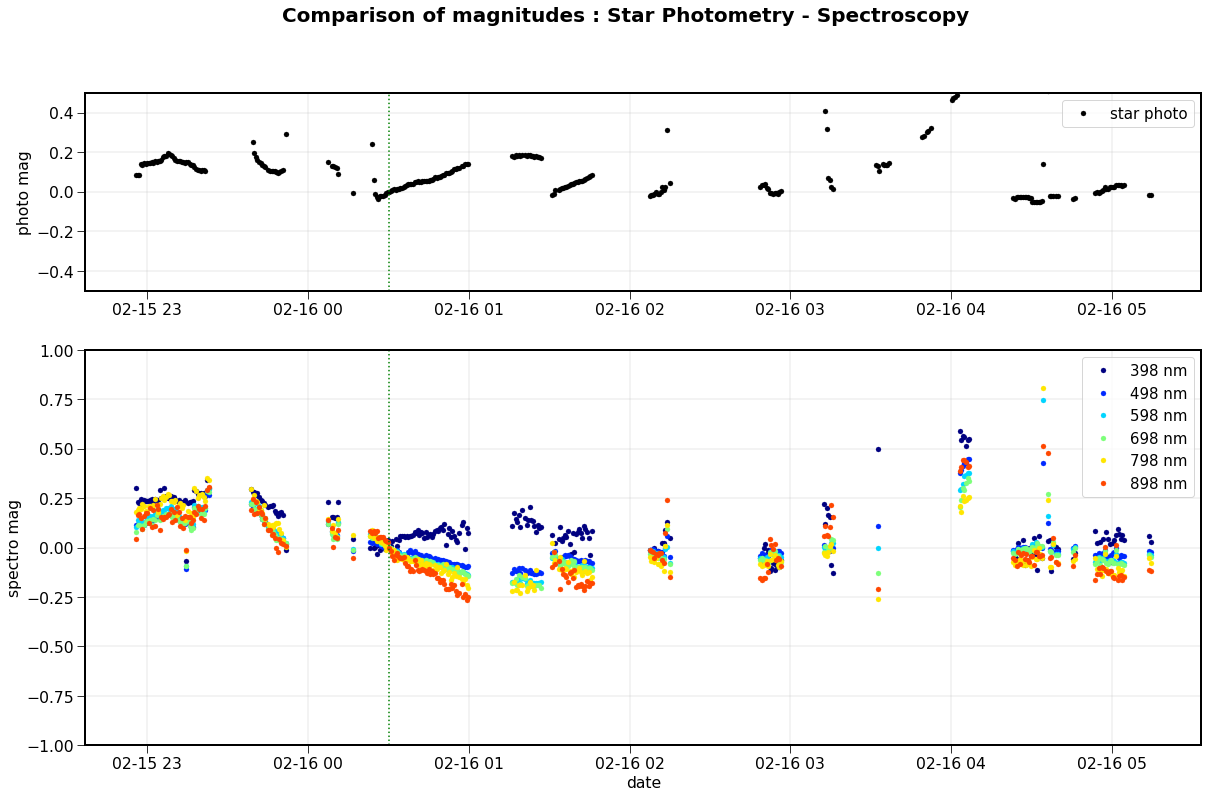

In [86]:
plt.figure(figsize=(20,12))

gs = gridspec.GridSpec(2, 1,height_ratios=[1, 2])

ax1 = plt.subplot(gs[0,0])
ax1.plot(all_datetime1,t["starmag"]-t["starmag"][idx_ref],'ko',label="star photo")
#ax1.set_ylim(-16.5,-15.5)
ax1.set_ylim(-0.5,0.5)
ax1.plot([all_datetime1[idx_ref],all_datetime1[idx_ref]],[-0.5,0.5],'g:')


ax1.set_ylabel("photo mag")
ax1.grid()
ax1.legend(fontsize=15)
ax2 = plt.subplot(gs[1,0],sharex=ax1)

count=0
for iwl in all_idx:

    ax2.plot(all_datetime1,MAttenuation_mean_ALL[iwl,map_photo_to_spectro_idx],'o',
             color=all_colors[count],label="{:3.0f} nm".format(Lambdas_ref[iwl]))
    
    count+=1
ax2.plot([all_datetime1[idx_ref],all_datetime1[idx_ref]],[-1,1],'g:')


ax2.grid()
ax2.legend(fontsize=15)
ax2.set_ylabel("spectro mag")
ax2.set_ylim(-1.,1.)
ax2.set_xlabel("date")
plt.suptitle("Comparison of magnitudes : Star Photometry - Spectroscopy",fontweight="bold",fontsize=20)

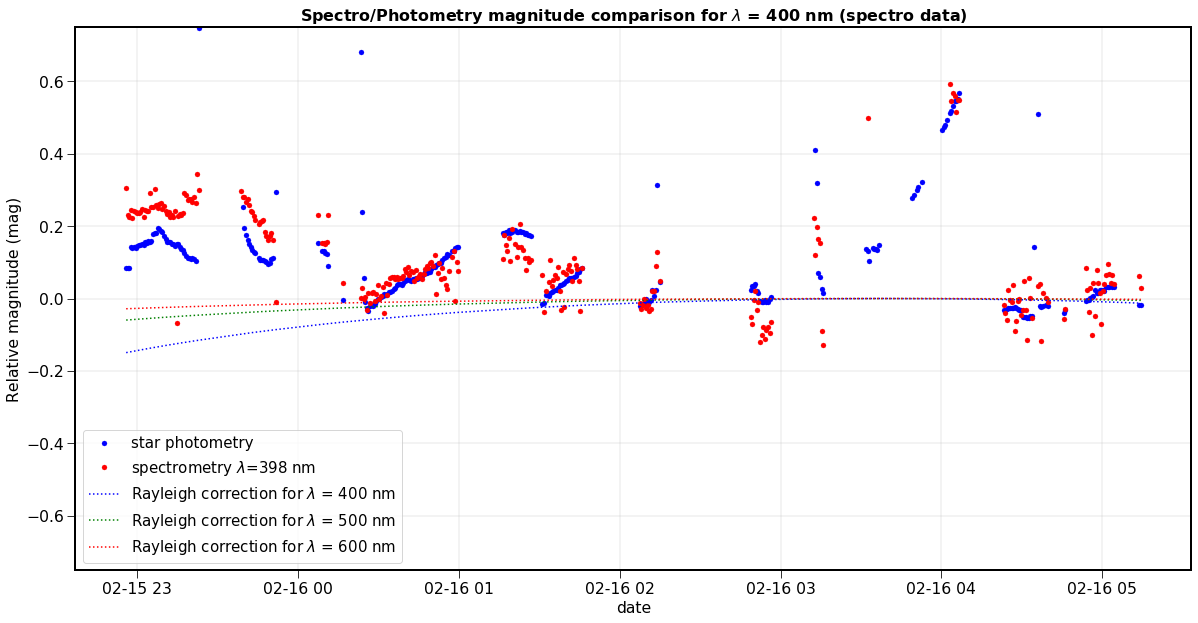

In [78]:
plt.figure(figsize=(20,10))
plt.plot(all_datetime1,t["starmag"]-t["starmag"][idx_ref],'bo',label="star photometry")
plt.plot(all_datetime1,MAttenuation_mean_ALL[all_idx[0],map_photo_to_spectro_idx],'ro',label="spectrometry $\lambda$={:3.0f} nm".format(Lambdas_ref[all_idx[0]]))
plt.ylim(-0.75,0.75)
plt.grid()
plt.legend()
colors=["b","g","r"]
ii=0
for wl in [400.,500.,600.]:
    od_adiab = RayOptDepth_adiabatic(wl,altitude=2890.5, costh=1./t["airmass"]) - RayOptDepth_adiabatic(wl,altitude=2890.5, costh=1.) # Rayleigh optical depth
    label="Rayleigh correction for $\lambda$ = {:3.0f} nm".format(wl)
    plt.plot(all_datetime1,-2.5/np.log(10.)*od_adiab,':',color=colors[ii],label=label)
    ii+=1
    
plt.title("Spectro/Photometry magnitude comparison for $\lambda$ = 400 nm (spectro data)")
plt.xlabel("date")
plt.ylabel("Relative magnitude (mag)")
plt.legend(fontsize=15)

In [71]:
am=t["airmass"]
od_adiab = RayOptDepth_adiabatic(500.,altitude=2890.5, costh=1./am)  -  RayOptDepth_adiabatic(500.,altitude=2890.5, costh=1)# Rayleigh optical depth

# absorption magnitude corrected from Rayleigh attenuation
abs=t["starmag"]-2.5/np.log(10.)*od_adiab

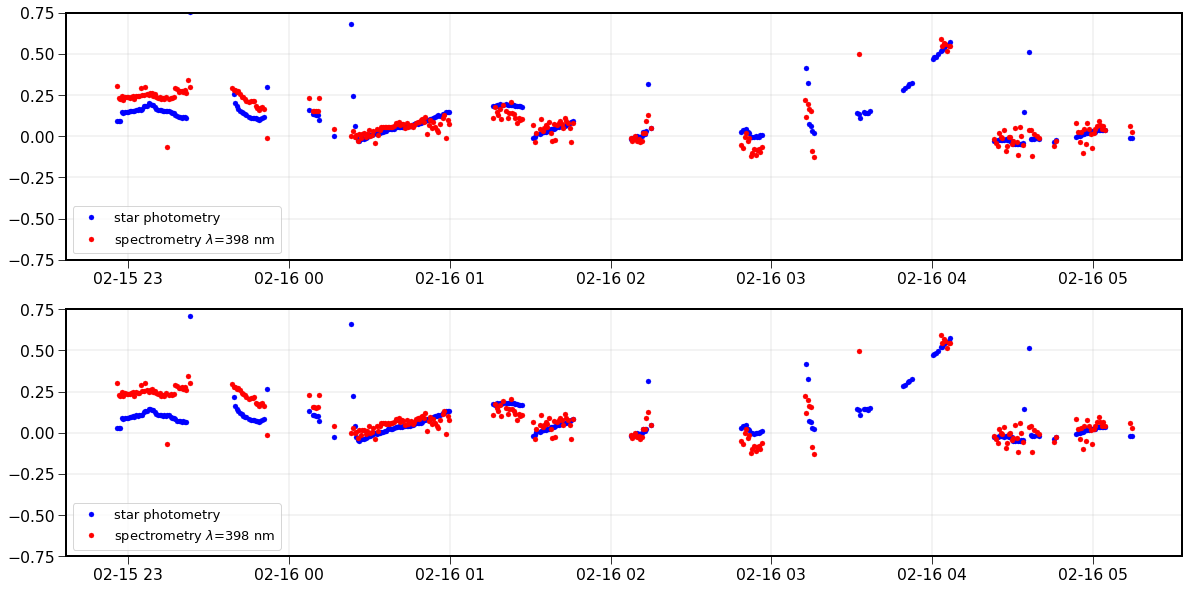

In [72]:
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.plot(all_datetime1,t["starmag"]+16.2,'bo',label="star photometry")
plt.plot(all_datetime1,MAttenuation_mean_ALL[all_idx[0],map_photo_to_spectro_idx],'ro',label="spectrometry $\lambda$={:3.0f} nm".format(Lambdas_ref[all_idx[0]]))
plt.ylim(-0.75,0.75)
plt.grid()
plt.legend()
plt.subplot(2,1,2)
plt.plot(all_datetime1,abs+16.2,'bo',label="star photometry")
plt.plot(all_datetime1,MAttenuation_mean_ALL[all_idx[0],map_photo_to_spectro_idx],'ro',label="spectrometry $\lambda$={:3.0f} nm".format(Lambdas_ref[all_idx[0]]))
plt.ylim(-0.75,0.75)
plt.grid()
plt.legend()

In [73]:
am=t["airmass"]
od_adiab = RayOptDepth_adiabatic(500.,altitude=2890.5, costh=1./am)  # Rayleigh optical depth

# absorption magnitude corrected from Rayleigh attenuation
abs=t["starmag"]-2.5/np.log(10.)*od_adiab

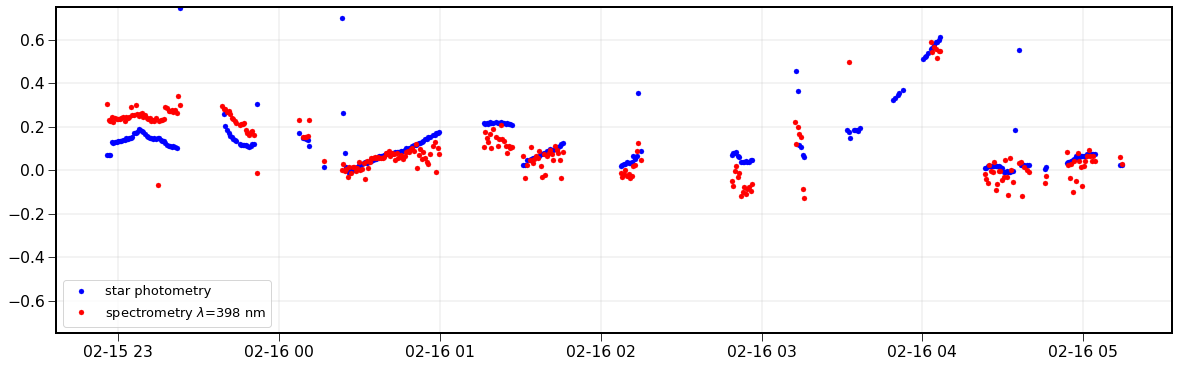

In [74]:
plt.figure(figsize=(20,6))
plt.plot(all_datetime1,abs+16.35,'bo',label="star photometry")
plt.plot(all_datetime1,MAttenuation_mean_ALL[all_idx[0],map_photo_to_spectro_idx],'ro',label="spectrometry $\lambda$={:3.0f} nm".format(Lambdas_ref[all_idx[0]]))
plt.ylim(-0.75,0.75)
plt.grid()
plt.legend()